In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import numpy as np
from sklearn.cluster import KMeans
import random
import itertools 

In [4]:
#read from files
df1= pd.read_csv('Old_Format_Of_Share_Holding_Pattern_Top_100_MarCap.csv')
df2= pd.read_csv('Daily_Adjusted_Share_Prices_Top_100_Market_Cap.csv')
df3= pd.read_csv('Monthly_Adjusted_Share_Prices_Top_100_Market_Cap.csv')
df4= pd.read_csv('New_Format_Of_Share_Holding_Pattern_Top_100_MarCap.csv')
df5= pd.read_csv('NIFTY_50_Data.csv')

In [5]:
#Top 100 companies by market cap
Comp = ['Ashok Leyland', 'Asian Paints', 'Bajaj Holdings', 'Bharat Forge',
       'Britannia Inds.', 'Cipla', 'Colgate-Palm.', 'Eicher Motors',
       'Ambuja Cem.', 'Grasim Inds', 'H D F C', 'Hero Motocorp',
       'Hindalco Inds.', 'Hind. Unilever', 'ITC', 'Larsen & Toubro',
       'M & M', 'Bosch', 'MRF', 'Piramal Enterp.', 'Reliance Inds.',
       'P & G Hygiene', 'Vedanta', 'Shree Cement', 'Siemens',
       'Tata Motors', 'Tata Steel', 'Wipro', "Dr Reddy's Labs",
       'Titan Company', 'St Bk of India', 'Shriram Trans.', 'B P C L',
       'Bharat Electron', 'S A I L', 'H P C L', 'B H E L', 'Hind.Zinc',
       'Kotak Mah. Bank', 'UPL', 'Infosys', 'Motherson Sumi', 'Lupin',
       'Zee Entertainmen', 'Pidilite Inds.', 'Havells India',
       'Dabur India', 'Bajaj Fin.', 'Sun Pharma.Inds.', 'Aurobindo Pharma',
       'JSW Steel', 'HDFC Bank', 'TCS', 'ICICI Bank', 'Power Grid Corpn',
       'Bank of Baroda', 'General Insuranc', 'Maruti Suzuki',
       'IndusInd Bank', 'Axis Bank', 'O N G C', 'DLF', 'TVS Motor Co.',
       'United Spirits', 'NTPC', 'I O C L', 'Coal India',
       'Hind.Aeronautics', 'NMDC', 'New India Assura', 'GAIL (India)',
       'Marico', 'Container Corpn.', 'Oracle Fin.Serv.', 'Biocon',
       'Sun TV Network', 'Bharti Airtel', 'Tech Mahindra', 'Petronet LNG',
       "Divi's Lab.", 'Adani Ports', 'Godrej Consumer', 'HDFC Stand. Life',
       'ICICI Pru Life', 'SBI Life Insuran', 'ICICI Lombard',
       'UltraTech Cem.', 'Yes Bank', 'Bajaj Auto', 'Bajaj Finserv',
       'Interglobe Aviat', 'Indiabulls Hous.', 'Aditya Birla Cap',
       'Avenue Super.', 'Bandhan Bank']

In [6]:
#convert date in appropriate format
df1['[Shareholding Date](All)'] = pd.to_datetime(df1['[Shareholding Date](All)'],format='%d/%m/%Y')
df2['[Date](All)'] = pd.to_datetime(df2['[Date](All)'],format='%d/%m/%Y')
df4['[Shareholding date](All)'] = pd.to_datetime(df4['[Shareholding date](All)'],format='%d/%m/%Y')
df5['Date'] = pd.to_datetime(df5['Date'],format='%d %b %Y')

In [7]:
#Sort each company share record by date 
for company in Comp:
    df1.loc[df1['Company Names'] == company].sort_values(['[Shareholding Date](All)'], ascending=[True])

In [8]:
#make array of dates, starting from startDate to <=endDate with period of monthOffset months
def makeDateArray(startDate,monthOffset,endDate):# date format: 'YYYY-MM-DD'
    start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
    end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
    dates = []
    while start<= end:
        dates.append(start)
        start = start+ pd.DateOffset(months=monthOffset)
    return dates

dates = makeDateArray('2008-01-01',6,'2018-07-01')
# dates

In [9]:
#find cluster of stocks with given period start date and end date (day after last day of period) and given k, which have highest mean TVP
#investorType can be 'Foreign' or 'Institutional'
def StockSelection(startDate,endDate,k,investorType):
    columns = ['Company','Return', 'Foreign','Institutional', 'Individual', 'Volume Ratio']
    Features = pd.DataFrame(columns=columns)
    # _Incomplete_Companies = ['General Insuranc', 'Coal India','Hind.Aeronautics','New India Assura','HDFC Stand. Life','ICICI Pru Life','SBI Life Insuran','ICICI Lombard','Interglobe Aviat','Indiabulls Hous.', 'Aditya Birla Cap','Avenue Super.', 'Bandhan Bank']
    for company in Comp:
        _df1 =  df1.loc[df1['Company Names'] == company].sort_values(['[Shareholding Date](All)'], ascending=[True])
        _df2 =  df2.loc[df2['Company Names'] == company].sort_values(['[Date](All)'], ascending=[True])
        start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
        end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
        __df1 = _df1.loc[_df1['[Shareholding Date](All)']>=start].loc[_df1['[Shareholding Date](All)']<end]  
        __df2 = _df2.loc[_df2['[Date](All)']>=start].loc[_df2['[Date](All)']<end] 
        
        #no record found in given range of date
        if __df1.shape[0]==0:
            a = _df1.loc[_df1['Company Names'] == company].loc[_df1['[Shareholding Date](All)']<start]
            previous = a.loc[a['[Shareholding Date](All)']==a['[Shareholding Date](All)'].max()]
            b = _df1.loc[_df1['Company Names'] == company].loc[_df1['[Shareholding Date](All)']<previous['[Shareholding Date](All)'].max()]
            previous2 = b.loc[b['[Shareholding Date](All)']==b['[Shareholding Date](All)'].max()]
            __df1 = __df1.append(previous)
            __df1 = __df1.append(previous2)
            __df1 = __df1.sort_values(['[Shareholding Date](All)'], ascending=[True])
        
        #onlu one record is found in given range of date
        elif __df1.shape[0]==1:
            a = _df1.loc[_df1['Company Names'] == company].loc[_df1['[Shareholding Date](All)']<start]
            previous = a.loc[a['[Shareholding Date](All)']==a['[Shareholding Date](All)'].max()]
            __df1 = __df1.append(previous)
            __df1 = __df1.sort_values(['[Shareholding Date](All)'], ascending=[True])

        if __df1.shape[0]>1 :
            return_ratio = __df2.iloc[[0, -1]]['[Close Price](All)'].diff(1).sum()/__df2.iloc[0]['[Close Price](All)'].sum()
            __df2['Diff'] = __df2['[Close Price](All)'].diff(-1)
            # doubt: diff(1) or diff(-1); refer to https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html
            up_volume = __df2.loc[__df2['Diff']>0]['[Total Volume](All)'].sum()
            down_volume = __df2.loc[__df2['Diff']<0]['[Total Volume](All)'].sum()
            volume_ratio = up_volume/float(down_volume) if down_volume>0 else 0
            foreign = __df1['[Total Foreign](All)'].diff(1).abs().sum()
            institutional = __df1['[Total Institutions](All)'].diff(1).abs().sum()
            individual =    __df1['[Total Public & Others](All)'].diff(1).abs().sum()
            govt =    __df1['[Total Govt Holding](All)'].diff(1).abs().sum()
            corporate_holding =  __df1['[Total Non Promoter Corporate Holding](All)'].diff(1).abs().sum()
            promoters =__df1['[Total Promoters](All)'].diff(1).abs().sum()
            total = foreign + institutional + individual + govt + corporate_holding + promoters
            foreign_trade_proportion = (1.0*foreign)/total if total>0 else 0
            institutional_trade_proportion = (1.0*institutional)/total if total>0 else 0
            individual_trade_proportion = (1.0 *individual)/ (total) if total>0 else 0
            Features = Features.append({'Company': company,'Return' : return_ratio ,'Volume Ratio': volume_ratio, 'Foreign': foreign_trade_proportion, 'Institutional' : institutional_trade_proportion, 'Individual':individual_trade_proportion}, ignore_index=True)
#     Features
    Clustered = pd.DataFrame()
    NameOfFeatures = Features['Company']
    Features = Features.drop(['Company'], axis=1)
    if Features.shape[0]>1 :
        dataset_array = Features.values
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(dataset_array)
        # Get cluster assignment labels
        labels = kmeans.labels_
        # Format results as a DataFrame
        results = pd.DataFrame([Features.index,labels]).T
        #print results
        Features['Cluster Number'] = pd.Series(labels, index=Features.index)
        Features['Company'] = NameOfFeatures
        Clustered=Clustered.append(Features)

    #find mean of every column corresponding to each cluster number
    #print Clustered
    if len(Clustered.index)>0:
        aggr = Clustered.groupby(['Cluster Number']).mean()
        foreign_cluster_number = aggr.loc[aggr['Foreign'] == aggr['Foreign'].max()].index[0]
        insti_cluster_number = aggr.loc[aggr['Institutional'] == aggr['Institutional'].max()].index[0]
    #     cluster_number = foreign_cluster_number if aggr['Foreign'].max() > aggr['Institutional'].max() else insti_cluster_number
        cluster_number = foreign_cluster_number if investorType=='Foreign' else insti_cluster_number
        #cluster_number is the cluster with highest mean TVP 
        cluster = Clustered.loc[Clustered['Cluster Number'] == cluster_number]
        #stocks in selected cluster
        return list(cluster['Company'])
    return []

x = StockSelection('2009-09-01','2010-03-01',5,'Institutional') 
print x

['Bajaj Holdings', 'Britannia Inds.', 'Colgate-Palm.', 'Ambuja Cem.', 'Grasim Inds', 'H D F C', 'Hero Motocorp', 'Hind. Unilever', 'M & M', 'MRF', 'Piramal Enterp.', 'Reliance Inds.', 'B P C L', 'H P C L', 'B H E L', 'Kotak Mah. Bank', 'UPL', 'Zee Entertainmen', 'HDFC Bank', 'ICICI Bank', 'Power Grid Corpn', 'Maruti Suzuki', 'O N G C', 'DLF', 'NTPC', 'I O C L', 'GAIL (India)', 'Marico', 'Container Corpn.', 'Oracle Fin.Serv.', 'Biocon', 'Bharti Airtel', 'Tech Mahindra', 'Petronet LNG', "Divi's Lab.", 'Adani Ports', 'Godrej Consumer', 'Bajaj Finserv']


In [10]:
def equalWeightVector(stockList):
    l=len(stockList)
    w = [1.0/l]*l
    return w

#return market capitalization weights known before start of given day
def marketCapitalizationWeightVector(stockList,date_):
    w = []
    _date = pd.to_datetime(np.datetime64(date_, dtype='datetime64[D]'))
    for stock in stockList:
        a = df2.loc[df2['Company Names'] == stock].loc[df2['[Date](All)']<_date]
        b = a.loc[a['[Date](All)']==a['[Date](All)'].max()]
        if(len(b.index)>0):
            marketCap = b.iloc[0]['[Market Cap](All)']
        w.append(marketCap)
    w = np.array(w)/sum(w)
    return w
   
# portfolioReturnPercentage([0.5,0.5],['Ashok Leyland','Asian Paints'],'2008-01-03','2008-01-06')
# equalWeightReturnPercentageVector(['Ashok Leyland','Asian Paints'],'2008-01-03','2008-01-06')
marketCapitalizationWeightVector(['Ashok Leyland','Asian Paints'],'2009-01-02')

array([ 0.19489927,  0.80510073])

In [11]:
#find profit(return) in given period with given weight vector for given set of stocks
#w is weight vector assigned to selectedStoks vector
#startDate and endDate are in form of 'YYYY-MM-DD'
#startDate is date of purchase at start of the day, endDate is date of sell at start of day.
def portfolioReturnPercentage(w, selectedStocks, startDate, endDate):
    w = np.array(w)/sum(w)
    start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
    end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
    portfolioReturnPercentage_ = 0
    for i,stock in enumerate(selectedStocks):
        a = df2.loc[df2['Company Names'] == stock].loc[df2['[Date](All)']>=start]
        purchase = a.loc[a['[Date](All)']==a['[Date](All)'].min()]
        #find earliest purchase >=startDate
        purchasePrice = purchase.iloc[0]['[Open Price](All)']
        b = a.loc[a['Company Names'] == stock].loc[a['[Date](All)']<=end]
        #find latest sell <=endDate
        sell = b.loc[b['[Date](All)']==b['[Date](All)'].max()]
        if(len(sell.index)>0):
            sellPrice = sell.iloc[0]['[Open Price](All)']
            portfolioReturnPercentage_ = portfolioReturnPercentage_ + w[i]*(sellPrice - purchasePrice)*100.0/purchasePrice
#         print purchase, sell, '\n',purchasePrice, sellPrice, portfolioReturnPercentage
    return portfolioReturnPercentage_

portfolioReturnPercentage([0.5,0.5],['Ashok Leyland','Asian Paints'],'2008-01-03','2008-01-06')

1.5526920434895948

In [12]:
def portfoliovariance(w,C): #w is row vector of weight and C is covariance matrix of set of stocks
    wDotC=np.dot(w,C)
    return np.dot(wDotC,np.array(w).T)

x = portfoliovariance([1,2],[[1,3],[5,7]])
print x

45


In [13]:
def genPop(n,chromGenfuncs, chromGenParams):
#Return a population (list) of N unique individuals.
#Each individual has len(chromgGenFuncs) chromosomes.
#For each individual, chromosome_i is generated by calling chromGenFuncs_i(chromeGenParams_i)
    answer = []
    chromGens = zip(chromGenfuncs, chromGenParams)
    while len(answer) < n:
        indiv = []
        for genfunc, genparams in chromGens:
            indiv.append(float(genfunc(*genparams)))
        #indiv = np.array(indiv)/sum(indiv)
        answer.append(indiv)
    return list(answer)

def generatePopulation(n,length): #n=number of chromosom, length=length of each chromosome
    population = genPop(n,[random.uniform]*length,[(0,1)]*length)
    return population

x = generatePopulation(5,2)
x

[[0.34830830524949685, 0.17244471059124877],
 [0.2885188382770203, 0.4008084346104964],
 [0.6972547517885795, 0.38065358007266303],
 [0.06491999813919591, 0.7415299141428521],
 [0.5560179913087484, 0.29463087705787905]]

In [14]:
def covarianceMatrix(stocksList,startDate,endDate):
    start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
    end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
    stocks=[]
    for stock in stocksList:
        a = df2.loc[df2['Company Names'] == stock].sort_values(['[Date](All)'], ascending=[True]).loc[df2['[Date](All)']>=start].loc[df2['[Date](All)']<end]
        x = np.array(a['[Open Price](All)'])
        stocks.append(x)
    return np.cov(stocks)
    
covarianceMatrix(['Ashok Leyland','Asian Paints'],'2008-01-06','2008-07-01')
    
# lower the portfolio variance, higher the fitness of chromosome
def minVarFitness(chromosome,stocksList,startDate,endDate):
    C = covarianceMatrix(stocksList,startDate,endDate)
    w = np.array(chromosome)/sum(chromosome)
    wDotC=np.dot(w,C)
    variance = np.dot(wDotC,np.array(w).T)
    return -1*variance

#nifty returns will act as return of reference asset
def niftyReturnPercentage(startDate,endDate):
    start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
    end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
    niftyReturnPercentage_ = 0
    a = df5.loc[df5['Date']>=start]
    purchase = a.loc[a['Date']==a['Date'].min()]
    b = df5.loc[df5['Date']<=end]
    sell = b.loc[b['Date']==b['Date'].max()]
    if(len(sell.index)>0):
        purchasePrice = purchase.iloc[0]['Open']
        sellPrice = sell.iloc[0]['Open']
        niftyReturnPercentage_ = (sellPrice - purchasePrice)*100.0/purchasePrice
    return niftyReturnPercentage_
    
# higher the sharpe ratop variance, higher the fitness of chromosome
def maxSharpeRatioFitness(chromosome,stocksList,startDate,endDate):
    C = covarianceMatrix(stocksList,startDate,endDate)
    w = np.array(chromosome)/sum(chromosome)
    wDotC=np.dot(w,C)
    variance = np.dot(wDotC,np.array(w).T)
    R_p = portfolioReturnPercentage(w,stocksList,startDate,endDate)
    R_f = niftyReturnPercentage(startDate,endDate)
    
    return (R_p-R_f)/(100.0*variance)

# minVarFitness([0.7,0.95],['Ashok Leyland','Asian Paints'],'2008-01-06','2008-07-01')

for y in x:
    print minVarFitness(y,['Ashok Leyland','Asian Paints'],'2008-01-06','2008-07-01')

for y in x:
    print maxSharpeRatioFitness(y,['Ashok Leyland','Asian Paints'],'2008-01-06','2008-07-01')
# def fitnessOfPopulation(pop,f)

-7.24399547281
-15.4234280744
-7.70022988165
-36.8687725248
-7.55419089557
0.0171656584941
0.0139164267186
0.0171790321067
0.00912920341575
0.017187345212


In [15]:
def singlePointMutaion(chromosome):
    mutated = []
    for i in chromosome:
        mutated.append(i)
    geneNumber = random.randint(0, len(chromosome)-1)
    gene = random.uniform(0,1)
#     while gene == float(chromosome[geneNumber]):
#         gene = random.uniform(0,1)
    mutated[geneNumber] = gene
    mutated = np.array(mutated)/sum(mutated)
#     print mutated
    return mutated

#There is scope of adding different type of mutation functions like 
#def swapMutation(chromosome):
#Pick any two random cities and swap their positions
#def revMutation(p, chrom):
#Choose a random pair of points on the chromosome.
#Reverse the order of the genes between those two points on the chromosome 

# print x
for i,y in enumerate(x):
#     print y
    x[i] = singlePointMutaion(y)
print x

[[0.34830830524949685, 0.17244471059124877], [0.2885188382770203, 0.4008084346104964], [0.6972547517885795, 0.38065358007266303], [0.06491999813919591, 0.7415299141428521], [0.5560179913087484, 0.29463087705787905]]
[array([ 0.81379313,  0.18620687]), array([ 0.62743947,  0.37256053]), array([ 0.57596595,  0.42403405]), array([ 0.48796262,  0.51203738]), array([ 0.5025188,  0.4974812])]


In [16]:
#Crossover
def crossOnes(p1,p2):
    if len(p1)<=1:
        return p1,p2
    else:
        crosspoint = random.randint(1, len(p1)-1)
    child1 = list(itertools.chain(p2[:crosspoint], p1[crosspoint:])) 
    child2 = list(itertools.chain(p1[:crosspoint],p2[crosspoint:]))
    child1 = np.array(child1)/sum(child1)
    child2 = np.array(child2)/sum(child2)
    return child1, child2

#There is scope of adding different type of crossover functions

print crossOnes(x[0],x[1])

(array([ 0.7711452,  0.2288548]), array([ 0.68596166,  0.31403834]))


In [17]:
#return index of chromosome with highest fitness
def selectHighest(scores):
    maximumIndex = 0
    maximumFitness = scores[0]
    for i,chromosomeFitness in enumerate(scores):
        if(maximumFitness<chromosomeFitness):
            maximumIndex = i
            maximumFitness = chromosomeFitness
    return maximumIndex
            

#return index of chromosome with highest and second highest fitness
def selectTop2(scores):
    maximumIndex = selectHighest(scores)
    minimumIndex = selectLowest(scores)
    maxFitness = scores[maximumIndex] 
    scores[maximumIndex] = scores[minimumIndex]
    secondMaximumIndex = selectHighest(scores)
    scores[maximumIndex] = maxFitness
    return maximumIndex, secondMaximumIndex

#return index of chromosome with lowest fitness
def selectLowest(scores):
    return selectHighest(-1*np.array(scores))

#return index of chromosome with highest and second highest fitness
def selectBottom2(scores):
    return selectTop2(-1*np.array(scores))

In [18]:
def addOneNewCromosomeToPopulation(newChromosome,population,scores,fitnessFunc, fitnessArgs):
    newScore = fitnessFunc(newChromosome, *fitnessArgs)
    lowIndex = selectLowest(scores)
    lowScore = scores[lowIndex]
    if lowScore<newScore:
        population[lowIndex] = newChromosome
        scores[lowIndex] = newScore
    return

In [19]:
#add mutation rate and crossover rate
def geneticAlgorithm(totalPopulation,fitnessFunc,stocksList,startDate, endDate, generations):
    population = generatePopulation(totalPopulation,len(stocksList))
    scores = []
    for i,chromosome in enumerate(population):
        scores.append(fitnessFunc(chromosome,stocksList,startDate,endDate))

    for i in xrange(generations):
        action = random.randint(0, len(chromosome)-1)
        # action 0 is for mutation and 1 for crossover
        if(i%100)==0:
            print i
        if action ==0:#mutn
            mutated = singlePointMutaion(population[random.randint(0,len(population)-1)])
            addOneNewCromosomeToPopulation(mutated,population,scores,fitnessFunc,(stocksList,startDate,endDate))
        if action == 1:#crossover
            highIndex1, highIndex2 = selectTop2(scores)
            cross1, cross2 = crossOnes(population[highIndex1],population[highIndex2])
            addOneNewCromosomeToPopulation(cross1,population,scores,fitnessFunc,(stocksList,startDate,endDate))
            addOneNewCromosomeToPopulation(cross2,population,scores,fitnessFunc,(stocksList,startDate,endDate))
    print scores
#     return scores,population
    return population[selectHighest(scores)]


geneticAlgorithm(5,minVarFitness,['Ashok Leyland','Asian Paints'],'2008-01-06','2008-07-01', 500)

0
100
200
300
400
[-5.4085995196023475, -5.4085995196023475, -5.4085995196023475, -5.4085995196023475, -5.4085995196023475]


array([ 0.85593495,  0.14406505])

In [20]:
# def evaluateTestingPeriod(totalPopulation,stocksList,startDate, endDate, generations):
#     start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
#     end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
#     equalWeightPortfolioReturn = 1
#     marketCapitalizationPortfolioReturn = 1
#     minVarianceFitnessPortfolioReturn = 1
#     maxSharpeFitnessPortfolioReturn = 1
#     NIFTY50Return = 1
#     print start
# #     columns = list(itertools.chain(['Buy Date', 'Sell Date', 'Equal Weight(Day)','Equal Weight(Cummulative)', 'Market Cap(Day)','Market Cap(Cummulative)', 'Min Var(Day)','Min Var(Cummulative)', 'Max Sharpe(Day)','Max Sharpe(Cummulative)'], stocksList)) # this is % of capital which was allocated to perticular companies stock stock 
#     columns = ['Buy Date', 'Sell Date', 'NIFTY50(Day)','NIFTY50(Cummulative)', 'Equal Weight(Day)','Equal Weight(Cummulative)', 'Market Cap(Day)','Market Cap(Cummulative)', 'Min Var(Day)','Min Var(Cummulative)', 'Max Sharpe(Day)','Max Sharpe(Cummulative)']
#     returnDf = pd.DataFrame(columns=columns)    
#     while start<=end:
#         start_ = start.strftime('%Y-%m-%d')
#         next_ = (start + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
#         prev_ = (start - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
#         previousMonth_ = (start-pd.DateOffset(months=1)).strftime('%Y-%m-%d')

#         rNIFTY = niftyReturnPercentage(start_,next_) #% 
#         NIFTY50Return =  (1+(rNIFTY/100.0))*NIFTY50Return
        
#         wEqWeight = equalWeightVector(stocksList)
#         wEqWeight = np.array(wEqWeight)/sum(wEqWeight)
#         rEqWeight = portfolioReturnPercentage(wEqWeight, stocksList, start_, next_)
#         equalWeightPortfolioReturn = (1+(rEqWeight/100.0))* equalWeightPortfolioReturn   
        
#         if rEqWeight !=0:
#             wMarCap = marketCapitalizationWeightVector(stocksList,start_)
#             wMarCap = np.array(wMarCap)/sum(wMarCap)
#             rMarCap = portfolioReturnPercentage(wMarCap, stocksList, start_, next_)
#             marketCapitalizationPortfolioReturn = (1+(rMarCap/100.0))* marketCapitalizationPortfolioReturn
            
#             wMinVar = geneticAlgorithm(totalPopulation,minVarFitness,stocksList,previousMonth_, prev_, generations)
#             wMinVar = np.array(wMinVar)/sum(wMinVar)
#             rMinVar = portfolioReturnPercentage(wMinVar, stocksList, start_, next_)
#             minVarianceFitnessPortfolioReturn = (1+(rMinVar/100.0))* minVarianceFitnessPortfolioReturn

#             wMaxSharpe = geneticAlgorithm(totalPopulation,maxSharpeRatioFitness,stocksList,previousMonth_, prev_, generations)
#             wMaxSharpe = np.array(wMaxSharpe)/sum(wMaxSharpe)
#             rMaxSharpe = portfolioReturnPercentage(wMaxSharpe, stocksList, start_, next_)
#             maxSharpeFitnessPortfolioReturn = (1+(rMaxSharpe/100.0))* maxSharpeFitnessPortfolioReturn
        
# #             values = list(itertools.chain([start_,next_, r, (portfolioReturn-1)*100],w))
#             values = [start,start + pd.DateOffset(days=1),rNIFTY,(NIFTY50Return-1)*100,rEqWeight,(equalWeightPortfolioReturn-1)*100,rMarCap,(marketCapitalizationPortfolioReturn-1)*100,rMinVar,(minVarianceFitnessPortfolioReturn-1)*100,rMaxSharpe,(maxSharpeFitnessPortfolioReturn-1)*100]
#             print values
#             returnDf = returnDf.append(pd.Series(values, index=returnDf.columns ), ignore_index=True)
#         start = start + pd.DateOffset(days=1)
#     return returnDf 


In [21]:
def evaluateHyperParameters(k,investorType,trainingWindowSize,startDate, endDate):
    start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
    end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
    equalWeightPortfolioReturn = 1
    marketCapitalizationPortfolioReturn = 1
    minVarianceFitnessPortfolioReturn = 1
    maxSharpeFitnessPortfolioReturn = 1
    NIFTY50Return = 1

#     print start
#     columns = list(itertools.chain(['Buy Date', 'Sell Date', 'Equal Weight(Day)','Equal Weight(Cummulative)', 'Market Cap(Day)','Market Cap(Cummulative)', 'Min Var(Day)','Min Var(Cummulative)', 'Max Sharpe(Day)','Max Sharpe(Cummulative)'], stocksList)) # this is % of capital which was allocated to perticular companies stock stock 
    columns = ['Buy Date', 'Sell Date', 'NIFTY50(Day)','NIFTY50(Cummulative)', 'Equal Weight(Day)','Equal Weight(Cummulative)', 'Market Cap(Day)','Market Cap(Cummulative)', 'Min Var(Day)','Min Var(Cummulative)', 'Max Sharpe(Day)','Max Sharpe(Cummulative)']
    returnDf = pd.DataFrame(columns=columns)    
    while start<=end:
        start_ = start.strftime('%Y-%m-%d')
        next_ = (start + pd.DateOffset(days=7)).strftime('%Y-%m-%d')
        trainingWindowStart = (start-pd.DateOffset(months=trainingWindowSize+1)).strftime('%Y-%m-%d')
        trainingWindowEnd = (start - pd.DateOffset(days=1)-pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        testingOfTraingWindowStart = (start -pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        testingOfTraingWindowEnd = (start -pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        stocksList = StockSelection(trainingWindowStart,trainingWindowEnd,k,investorType)
        totalPopulation = 50
        generations = 500
        
        rNIFTY = niftyReturnPercentage(start_,next_) #% 
        NIFTY50Return =  (1+(rNIFTY/100.0))*NIFTY50Return
        
        wEqWeight = equalWeightVector(stocksList)
        wEqWeight = np.array(wEqWeight)/sum(wEqWeight)
        rEqWeight = portfolioReturnPercentage(wEqWeight, stocksList, start_, next_)
        equalWeightPortfolioReturn = (1+(rEqWeight/100.0))* equalWeightPortfolioReturn
        
        wMarCap = marketCapitalizationWeightVector(stocksList,start_)
        wMarCap = np.array(wMarCap)/sum(wMarCap)
        rMarCap = portfolioReturnPercentage(wMarCap, stocksList, start_, next_)
        marketCapitalizationPortfolioReturn = (1+(rMarCap/100.0))* marketCapitalizationPortfolioReturn
        if rEqWeight!=0:
            wMinVar = geneticAlgorithm(totalPopulation,minVarFitness,stocksList,testingOfTraingWindowStart, testingOfTraingWindowEnd, generations)
            wMinVar = np.array(wMinVar)/sum(wMinVar)
            rMinVar = portfolioReturnPercentage(wMinVar, stocksList, start_, next_)
            minVarianceFitnessPortfolioReturn = (1+(rMinVar/100.0))* minVarianceFitnessPortfolioReturn

            wMaxSharpe = geneticAlgorithm(totalPopulation,maxSharpeRatioFitness,stocksList,testingOfTraingWindowStart, testingOfTraingWindowEnd, generations)
            wMaxSharpe = np.array(wMaxSharpe)/sum(wMaxSharpe)
            rMaxSharpe = portfolioReturnPercentage(wMaxSharpe, stocksList, start_, next_)
            maxSharpeFitnessPortfolioReturn = (1+(rMaxSharpe/100.0))* maxSharpeFitnessPortfolioReturn
        start = start + pd.DateOffset(days=7)

         
    maximumReturn = max(maxSharpeFitnessPortfolioReturn,minVarianceFitnessPortfolioReturn,marketCapitalizationPortfolioReturn,equalWeightPortfolioReturn)
    if (maxSharpeFitnessPortfolioReturn == maximumReturn):
        return maximumReturn, 'maxSharpeRatioFitness'
    elif (minVarianceFitnessPortfolioReturn == maximumReturn):
        return maximumReturn, 'minVarFitness'
    elif (marketCapitalizationPortfolioReturn == maximumReturn):
        return maximumReturn, 'marketCapitalizationWeight'
    else:
        return maximumReturn, 'equalWeight'
# evaluateHyperParameters(5,'Foreign',5,'2009-02-06', '2009-02-11')

In [22]:
#startDate = training period start date, endDate = training period end date
def hyperParameterTuningInTrainingPeriod(startDate,endDate): 
    maxReturnK = -1
    maxReturnInvestorType = ''
    maxReturnTrainingWindowSize = 1
    maxReturn = -5000
    for k in range(5,6):
        for investorType in ['Foreign','Institutional']:
            for trainingWindowSize in [3,6,12]:
                print ('Checking hyperparameters- k: ',k,' Investor type:', investorType, ' trainingWindowSize: ',trainingWindowSize)
                start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
                end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
                returnValue, returnFunction = evaluateHyperParameters(k,investorType,trainingWindowSize,startDate, endDate)
                if(returnValue>maxReturn):
                    maxReturn = returnValue
                    maxReturnK = k
                    maxReturnInvestorType = investorType
                    maxReturnTrainingWindowSize = trainingWindowSize
                    maxReturnFunction = returnFunction
                print (' return: ', returnValue, ' returnFunction: ', returnFunction)
    return k,investorType,trainingWindowSize, maxReturnFunction

# hyperParameterTuningInTrainingPeriod('2009-02-08', '2009-02-11')

In [23]:
def finalEvaluationInTestingPeriod(totalPopulation,stocksList,startDate, endDate, generations,fitnessFunc,initialNifty,initialOurs):
    start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
    end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
    equalWeightPortfolioReturn = initialOurs
    marketCapitalizationPortfolioReturn = initialOurs
    minVarianceFitnessPortfolioReturn = initialOurs
    maxSharpeFitnessPortfolioReturn = initialOurs
    NIFTY50Return = initialNifty
    print start
    columns = ['Buy Date', 'Sell Date', 'NIFTY50(Day)','NIFTY50(Cummulative)', 'Our Strategy(Day)','Our Strategy(Cummulative)']
    returnDf = pd.DataFrame(columns=columns)    
    while start<=end:
        start_ = start.strftime('%Y-%m-%d')
        next_ = (start + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        prev_ = (start - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        previousMonth_ = (start-pd.DateOffset(months=1)).strftime('%Y-%m-%d')

        rNIFTY = niftyReturnPercentage(start_,next_) #% 
        NIFTY50Return =  (1+(rNIFTY/100.0))*NIFTY50Return
        if(rNIFTY!=0):
            if(fitnessFunc == 'equalWeight'):
                wEqWeight = equalWeightVector(stocksList)
                wEqWeight = np.array(wEqWeight)/sum(wEqWeight)
                rEqWeight = portfolioReturnPercentage(wEqWeight, stocksList, start_, next_)
                equalWeightPortfolioReturn = (1+(rEqWeight/100.0))* equalWeightPortfolioReturn 
                values = [start,start + pd.DateOffset(days=1),rNIFTY,(NIFTY50Return-1)*100,rEqWeight,(equalWeightPortfolioReturn-1)*100]
            elif (fitnessFunc == 'marketCapitalizationWeight'):
                wMarCap = marketCapitalizationWeightVector(stocksList,start_)
                wMarCap = np.array(wMarCap)/sum(wMarCap)
                rMarCap = portfolioReturnPercentage(wMarCap, stocksList, start_, next_)
                marketCapitalizationPortfolioReturn = (1+(rMarCap/100.0))* marketCapitalizationPortfolioReturn
                values = [start,start + pd.DateOffset(days=1),rNIFTY,(NIFTY50Return-1)*100,rMarCap,(marketCapitalizationPortfolioReturn-1)*100]
        
            elif (fitnessFunc == 'minVarFitness'):
                wMinVar = geneticAlgorithm(totalPopulation,minVarFitness,stocksList,previousMonth_, prev_, generations)
                wMinVar = np.array(wMinVar)/sum(wMinVar)
                rMinVar = portfolioReturnPercentage(wMinVar, stocksList, start_, next_)
                minVarianceFitnessPortfolioReturn = (1+(rMinVar/100.0))* minVarianceFitnessPortfolioReturn
                values = [start,start + pd.DateOffset(days=1),rNIFTY,(NIFTY50Return-1)*100,rMinVar,(minVarianceFitnessPortfolioReturn-1)*100]
            elif (fitnessFunc == 'maxSharpeRatioFitness'):
                wMaxSharpe = geneticAlgorithm(totalPopulation,maxSharpeRatioFitness,stocksList,previousMonth_, prev_, generations)
                wMaxSharpe = np.array(wMaxSharpe)/sum(wMaxSharpe)
                rMaxSharpe = portfolioReturnPercentage(wMaxSharpe, stocksList, start_, next_)
                maxSharpeFitnessPortfolioReturn = (1+(rMaxSharpe/100.0))* maxSharpeFitnessPortfolioReturn
                values = [start,start + pd.DateOffset(days=1),rNIFTY,(NIFTY50Return-1)*100,rMaxSharpe,(maxSharpeFitnessPortfolioReturn-1)*100]
            print ('entry: ',values)
            returnDf = returnDf.append(pd.Series(values, index=returnDf.columns ), ignore_index=True)
        start = start + pd.DateOffset(days=1)
    if(fitnessFunc == 'equalWeight'):
        return returnDf, (NIFTY50Return), (equalWeightPortfolioReturn)
    elif (fitnessFunc == 'marketCapitalizationWeight'):
        return returnDf, (NIFTY50Return), (marketCapitalizationPortfolioReturn)
    elif (fitnessFunc == 'minVarFitness'):
        return returnDf, (NIFTY50Return), (minVarianceFitnessPortfolioReturn)
    elif (fitnessFunc == 'maxSharpeRatioFitness'):
        return returnDf, (NIFTY50Return), (maxSharpeFitnessPortfolioReturn)


In [24]:
def portfolioManagementAlgorithm(startDate, endDate):
    start = pd.to_datetime(np.datetime64(startDate, dtype='datetime64[D]'))
    end = pd.to_datetime(np.datetime64(endDate, dtype='datetime64[D]'))
    columns = ['Buy Date', 'Sell Date', 'NIFTY50(Day)','NIFTY50(Cummulative)', 'Our Strategy(Day)','Our Strategy(Cummulative)']
    returnDf = pd.DataFrame(columns=columns)
    initialNiftyReturns = 1
    initialOurReturns = 1
    while start<end:
        startTuning_ = (start - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        endTuning_ = (start - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        startTesting_ = start.strftime('%Y-%m-%d')
        endTesting_ = (start + pd.DateOffset(days=7)).strftime('%Y-%m-%d')        
        k,investorType,traingWinsowSize, maxReturnFunction = hyperParameterTuningInTrainingPeriod(startTuning_,endTuning_)
        startTrainingWindow = (start - pd.DateOffset(months=traingWinsowSize)).strftime('%Y-%m-%d')
        endTrainingWindow = (start - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        stocksList = StockSelection(startTrainingWindow,endTrainingWindow,k,investorType)
        df, niftyReturns, ourReturns = finalEvaluationInTestingPeriod(50,stocksList,startTesting_, endTesting_, 500,maxReturnFunction,initialNiftyReturns,initialOurReturns)
        initialNiftyReturns = niftyReturns
        initialOurReturns = ourReturns
        returnDf = returnDf.append(df)
        #change this months = 3 to appropriate
        start = start + pd.DateOffset(days=7)
    return returnDf     

In [27]:
dfFinal = portfolioManagementAlgorithm('2017-01-01', '2017-04-01')

('Checking hyperparameters- k: ', 5, ' Investor type:', 'Foreign', ' trainingWindowSize: ', 6)
0
100
200
300
400
[-113.50297640686664, -46.529475958313199, -136.2276744473148, -113.50455629215921, -109.69869309089069, -273.02907420596773, -45.458909390828005, -66.670772713542178, -48.011747253794212, -66.761176693445705, -225.66400132850771, -84.123458017077311, -125.52685995056441, -37.373910158015455, -285.54239754716059, -140.39509248470071, -44.292787453933848, -83.172045955646013, -48.718597570618641, -277.86881508582007, -294.68530103192592, -113.55377717542171, -113.5355256818014, -113.58634677850247, -328.95877854843866, -46.64803176016725, -34.286121614615865, -34.985084211986141, -300.59177440493829, -52.559879008726341, -121.28193458620513, -302.03058553633838, -292.63423447083545, -66.805780086308644, -113.50292347294828, -325.99199675006037, -67.640425910955273, -159.80071857950509, -36.758618713561802, -103.55128638924468, -68.073034502368884, -137.33141227828992, -113.50

In [29]:
portfolioManagementAlgorithm('2017-01-01', '2018-01-01')

,Buy Date,Sell Date,NIFTY50(Day),NIFTY50(Cummulative),Our Strategy(Day),Our Strategy(Cummulative)
0,2017-01-02,2017-01-03,-0.171131,-0.171131,1.926682,1.926682
1,2017-01-03,2017-01-04,0.080527,-0.090742,2.938892,4.922197
2,2017-01-04,2017-01-05,0.292588,0.201581,-0.369818,4.534176
3,2017-01-05,2017-01-06,0.670990,0.873924,0.751440,5.319688
4,2017-01-07,2017-01-08,0.272419,1.148723,0.000000,5.319688
0,2017-01-09,2017-01-10,0.040560,1.189749,0.205054,5.535650
1,2017-01-10,2017-01-11,0.787878,1.987001,0.498725,6.061983
2,2017-01-11,2017-01-12,0.759504,2.761596,-0.014977,6.046098
3,2017-01-12,2017-01-13,0.793703,3.577218,0.816412,6.911871
4,2017-01-14,2017-01-15,0.794904,4.400558,0.000000,6.911871


In [60]:
s = pd.to_datetime(np.datetime64('2017-04-01', dtype='datetime64[D]'))
dfFirstQuarter = dfFinal.loc[dfFinal['Buy Date']<=s]
dfFirstQuarter

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Buy Date,Sell Date,NIFTY50(Day),NIFTY50(Cummulative),Our Strategy(Day),Our Strategy(Cummulative)
0,2017-01-02,2017-01-03,-0.171131,-0.171131,1.926682,1.926682
1,2017-01-03,2017-01-04,0.080527,-0.090742,2.938892,4.922197
2,2017-01-04,2017-01-05,0.292588,0.201581,-0.369818,4.534176
3,2017-01-05,2017-01-06,0.670990,0.873924,0.751440,5.319688
4,2017-01-07,2017-01-08,0.272419,1.148723,0.000000,5.319688
0,2017-01-09,2017-01-10,0.040560,1.189749,0.205054,5.535650
1,2017-01-10,2017-01-11,0.787878,1.987001,0.498725,6.061983
2,2017-01-11,2017-01-12,0.759504,2.761596,-0.014977,6.046098
3,2017-01-12,2017-01-13,0.793703,3.577218,0.816412,6.911871
4,2017-01-14,2017-01-15,0.794904,4.400558,0.000000,6.911871


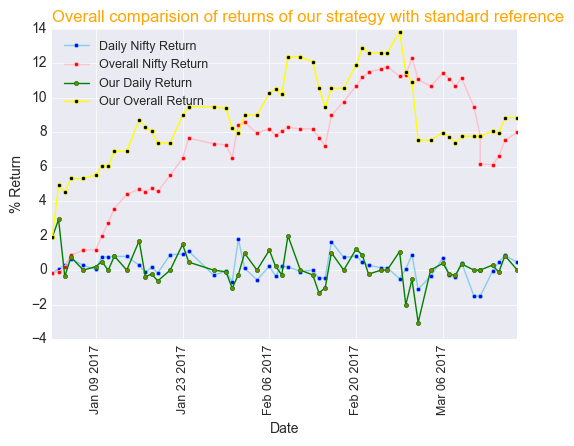

In [65]:
def plotFinalGraph(df):
    df["Buy Date"].dt.strftime('%d-%m-%Y')
    # style
    plt.clf()
    plt.style.use('seaborn-darkgrid')
    plt.plot('Buy Date', 'NIFTY50(Day)', data=df, marker='.', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=1, label="Daily Nifty Return")
    plt.plot( 'Buy Date', 'NIFTY50(Cummulative)', data=df, marker='.', markerfacecolor='red', markersize=6, color='pink', linewidth=1, label="Overall Nifty Return")
    plt.plot( 'Buy Date', 'Our Strategy(Day)', data=df, marker='.', markerfacecolor='olive', markersize=6, color='green', linewidth=1,label="Our Daily Return")
    plt.plot( 'Buy Date', 'Our Strategy(Cummulative)', data=df, marker='.', markerfacecolor='black', markersize=6, color='yellow', linewidth=1, label="Our Overall Return")
    # Add legend
    plt.legend(loc=2, ncol=1,fontsize=9)
    plt.xticks(fontsize=9, rotation=90)

    # Add titles
    plt.title("Overall comparision of returns of our strategy with standard reference", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Date")
    plt.ylabel("% Return")
    plt.show()
#     plt.savefig('JantoMar2017.png')
plotFinalGraph(dfFirstQuarter)